In [1]:
from datakit import *
from importlib import reload
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
import datakit
reload(datakit)
from datakit import *

__Read Main__

In [177]:
path = f'data_processed/main_new.csv'
df = pd.read_csv(path)

In [179]:
df[df.link.eq('https://www.otodom.pl/pl/oferta/okazja-3p-wysoki-standard-ID4uCtr')]

,added_dt,last_update,link,expired,expired_date,title,rent_price,area_room_num,floor,ogrzewanie,flat_condition,available_from,deposit,advertiser_type,additional_information,location,latitude,longitude,approximate_coordinates,year_of_construction,elevator,building_type,security,equipment,utilities,safeguards,adv_description,district
11556,2025_01_27,NaN,https://www.otodom.pl/pl/oferta/okazja-3p-wyso...,1,2025_02_13,Okazja 3P Wysoki Standard!,4 000 zł\n/miesiąc\n+ Czynsz 7 000 zł,50m²\n3 pokoje,7/8,NaN,do zamieszkania,2025-01-27,4 000 zł,biuro nieruchomości,balkon\ngaraż/miejsce parkingowe,"ul. Omulewska, Grochów, Praga-Południe, Warsza...",52.24133,21.0961,False,NaN,nie,NaN,NaN,meble\npiekarnik\nlodówka\npralka\ntelewizor\n...,NaN,NaN,We speak EN/PL/UA/RU\n\nDo wynajęcia przestron...,Praga-Południe


__Deduplicate records using dedicated function__

In [181]:
df = deduplicate_main(df)

__Transform scraped data using dedicated function__

In [183]:
df = transform_data(
    main = df,
    only_expired = True,
    duration_start = 1,
    duration_end = 28,
    utilize_morf = False
)

__Calculate distance columns using dedicated functions__

In [13]:
ztm_stops = pd.read_csv('geographic_data/ztm_stops/ztm_stops.csv')

In [14]:
df['distance_to_stop'] = distance_to_nearest_stop(df, ztm_stops)

In [15]:
subway_stations = ztm_stops[
    ztm_stops.stop_name.str.startswith('Metro')|
    ztm_stops.stop_name.str.contains('Wilsona')|
    ztm_stops.stop_name.str.contains('Daszyńskiego')|
    ztm_stops.stop_name.str.contains('Nowy Świat')|
    ztm_stops.stop_name.str.contains('ONZ')|
    ztm_stops.stop_name.str.contains('Wileński')|
    ztm_stops.stop_name.eq('Dw. Gdański')|
    ztm_stops.stop_name.eq('Centrum')].copy()

In [16]:
df['distance_to_subway'] = distance_to_nearest_stop(df, subway_stations)

In [17]:
df['distance_to_center'] = distance_to_center(df)

__Historical data__

In [19]:
legacy_data = concat_csv_files(folder_path='data_raw/otodom_scraped_data_historical')

In [20]:
legacy_data = legacy_data[~legacy_data.approximate_coordinates.eq(True)]

In [21]:
columns_to_convert = ['rent_price', 'additional_fees', 'area']
for column in columns_to_convert:
    legacy_data[column] = legacy_data[column].apply(lambda x: get_numbers(str(x)))
    
legacy_data['rent_price'] = legacy_data.apply(
    lambda row: row['rent_price'] + row['additional_fees']\
    if not pd.isna(row['additional_fees']) else row['rent_price'], 
    axis=1)

legacy_data['log_price_per_square'] = legacy_data.rent_price/legacy_data.area

In [22]:
df['avg_log_price'] = average_price_within_radius(df, legacy_data)

__Manually collected inputs__

In [24]:
additional_columns = pd.read_csv('data_raw/other/manual_input.csv')

In [25]:
df = df.merge(additional_columns, on='link')

__Modeling__

In [28]:
columns_to_drop = ['link', 'last_update', 'location', 'latitude', 'longitude']

modeling_df = df.copy()
modeling_df = modeling_df.drop(columns=columns_to_drop)

In [29]:
modeling_df.head(4)

,added_dt,floor,heating,advertiser_type,approximate_coordinates,elevator,building_type,safeguards,district,rent,additional_fees,area,room_number,students_allowed,non_smoker_only,building_height,for_renovation,balcony,terrace,garden,parking_space,separate_kitchen,utility_room,basement,gated_community,security_monitoring,building_age,cable_tv,internet,dishwasher,air_conditioning,distance_to_stop,distance_to_subway,distance_to_center,avg_log_price,is_furnished,apartment_class
0,2024-12-01,2.0,district,agency,0,1,tenement,0,Srodmiescie,2700,600,38.0,2.0,0,0,8.0,0,1,0,0,0,1,0,0,0,0,93.0,0,1,0,0,0.043828,0.644262,1.671,102.939267,1,basic
1,2024-12-01,10.0,district,agency,0,1,apartment,0,Wola,6900,1300,55.0,2.0,0,0,22.0,0,1,0,0,1,0,0,0,0,1,16.0,1,1,1,0,0.088196,0.332013,1.710,127.286920,1,superior
2,2024-12-01,3.0,district,owner,0,1,block_of_flats,1,Bielany,2900,770,56.0,2.0,0,1,5.0,0,1,0,0,1,0,0,0,0,0,16.0,1,1,1,0,0.430110,1.410617,10.171,82.153009,1,basic
3,2024-12-01,8.0,district,agency,0,1,other,1,Targowek,1950,736,35.0,1.0,0,0,8.0,0,0,0,0,0,0,0,0,1,0,24.0,1,1,0,0,0.176824,0.176824,7.208,81.727041,1,basic


In [30]:
input_missing_values(modeling_df)

In [31]:
df_encoded = pd.get_dummies(
    modeling_df,
    columns=['heating', 'advertiser_type', 'building_type', 'apartment_class'],
    prefix={'heating': 'heating', 'advertiser_type': 'at', 'building_type': 'bt', 'apartment_class': 'ac'},
    prefix_sep='_',
    dtype=int)

district_dummies = pd.get_dummies(df['district'], prefix='', prefix_sep='', dtype=int)
modeling_df = pd.concat([df_encoded.drop('district', axis=1), district_dummies], axis=1)

In [32]:
modeling_df.head(4)

,added_dt,floor,approximate_coordinates,elevator,safeguards,rent,additional_fees,area,room_number,students_allowed,non_smoker_only,building_height,for_renovation,balcony,terrace,garden,parking_space,separate_kitchen,utility_room,basement,gated_community,security_monitoring,building_age,cable_tv,internet,dishwasher,air_conditioning,distance_to_stop,distance_to_subway,distance_to_center,avg_log_price,is_furnished,heating_boiler room,heating_district,heating_electric,heating_gas,heating_other,at_agency,at_developer,at_owner,bt_apartment,bt_block_of_flats,bt_other,bt_tenement,ac_basic,ac_premium,ac_standard,ac_superior,Bemowo,Bialoleka,Bielany,Mokotow,Ochota,Praga_Polnoc,Praga_Poludnie,Rembertow,Srodmiescie,Targowek,Ursus,Ursynow,Wawer,Wesola,Wilanow,Wlochy,Wola,Zoliborz
0,2024-12-01,2.0,0,1,0,2700,600,38.0,2.0,0,0,8.0,0,1,0,0,0,1,0,0,0,0,93.0,0,1,0,0,0.043828,0.644262,1.671,102.939267,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2024-12-01,10.0,0,1,0,6900,1300,55.0,2.0,0,0,22.0,0,1,0,0,1,0,0,0,0,1,16.0,1,1,1,0,0.088196,0.332013,1.710,127.286920,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2024-12-01,3.0,0,1,1,2900,770,56.0,2.0,0,1,5.0,0,1,0,0,1,0,0,0,0,0,16.0,1,1,1,0,0.430110,1.410617,10.171,82.153009,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2024-12-01,8.0,0,1,1,1950,736,35.0,1.0,0,0,8.0,0,0,0,0,0,0,0,0,1,0,24.0,1,1,0,0,0.176824,0.176824,7.208,81.727041,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [33]:
modeling_df['rent'] = modeling_df['rent'] + modeling_df['additional_fees']

__-----__

In [35]:
train_df = modeling_df[modeling_df.added_dt.le('2025-01-25')].copy()
out_of_time_sample = modeling_df[modeling_df.added_dt.ge('2025-01-26')&modeling_df.added_dt.le('2025-02-04')].copy()

train_df = train_df.drop(["added_dt", 'additional_fees'], axis=1)
out_of_time_sample = out_of_time_sample.drop(["added_dt", 'additional_fees'], axis=1)

In [36]:
y_col = 'rent'
x_cols = [col for col in train_df.columns if col != y_col]

X_train = train_df.drop([y_col], axis=1)
y_train = train_df[y_col]
X_out_of_time = out_of_time_sample.drop([y_col], axis=1)
y_out_of_time = out_of_time_sample[y_col]

In [37]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, RandomizedSearchCV

In [38]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [39]:
params = {
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1,
    "n_estimators": 150
}

model = XGBRegressor(**params)

cv_results = cross_validate(
    model, X_train, y_train, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-561.3001195  -532.05565722 -591.37700687 -573.93854459 -576.32459776]
MAE Test: [-732.85917847 -791.28757669 -567.8685181  -632.30329908 -625.92515331]
Mean MAE Test: -670.04874513105
-------------------
R2 Train: [0.91585608 0.93117736 0.90504622 0.90483005 0.90864004]
R2 Test: [0.81690264 0.75993862 0.91377367 0.90490164 0.84410002]
Mean R2 Test: 0.8479233170560274
-------------------
MAPE Train: [-0.11541325 -0.11129477 -0.11840834 -0.11378494 -0.11343774]
MAPE Test: [-0.12788237 -0.12847528 -0.11623781 -0.13115814 -0.13320776]
Mean MAPE Test: -0.12739227196622832


In [40]:
# Initialize and train the model on the full training set
model = XGBRegressor(**params)
model.fit(X_train, y_train)

# Predict on the out‐of‐time sample
y_pred_oot = model.predict(X_out_of_time)

# Calculate scoring metrics for the OOT sample
mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

# Print out the results
print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 644.8208538552989
R2: 0.8535094424987544
MAPE: 0.1368616758471008


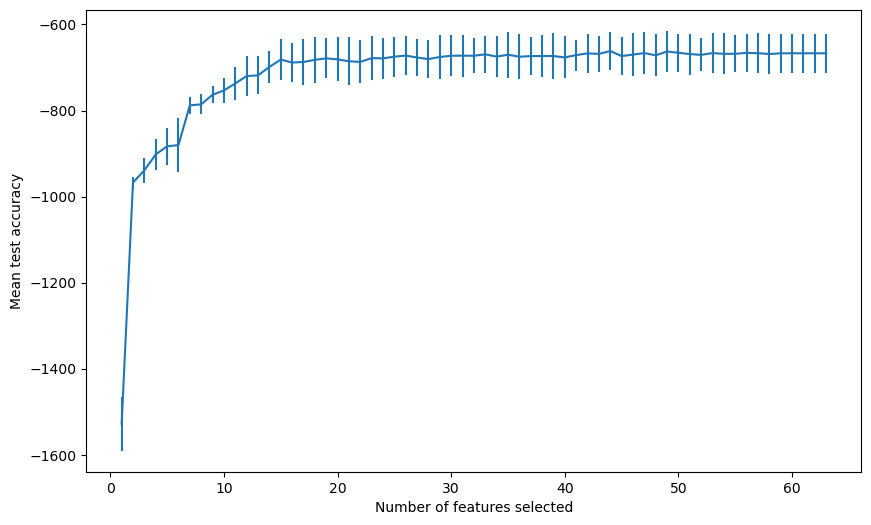

In [41]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# Initialize your XGBRegressor
xgb_reg = XGBRegressor()

# Define a cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RFECV with negative mean squared error as the scoring metric.
rfecv = RFECV(estimator=xgb_reg, step=1, cv=cv, scoring='neg_mean_absolute_error')

# Fit RFECV on your training data
rfecv.fit(X_train, y_train)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [195]:
print("Optimal number of features:", rfecv.n_features_)

Optimal number of features: 44


In [68]:
rfecv.cv_results_["mean_test_score"]

array([-1528.12750297,  -967.33451344,  -938.84648728,  -902.03024345,
        -883.21466781,  -880.31480455,  -788.03711244,  -785.54986419,
        -763.35788598,  -753.28024825,  -737.05172195,  -719.96651755,
        -718.23538535,  -698.75186549,  -681.56589686,  -688.43958938,
        -687.20048238,  -682.242758  ,  -678.69572009,  -681.05194244,
        -685.52365046,  -686.99270246,  -678.24292702,  -678.74823053,
        -674.81305515,  -672.33454756,  -676.69127282,  -680.50158282,
        -675.48099484,  -672.65805499,  -672.47897544,  -672.73340583,
        -669.33930141,  -674.59182993,  -670.31659471,  -674.91130299,
        -673.47779623,  -673.41965096,  -673.33591404,  -676.58535587,
        -671.16543533,  -667.16455566,  -668.37937822,  -661.68651441,
        -673.45013246,  -669.97476121,  -666.41700243,  -671.64254108,
        -662.79934356,  -665.79274453,  -668.82891784,  -670.63038477,
        -666.46743301,  -668.17892124,  -668.14244818,  -665.89994547,
      

In [199]:
from sklearn.feature_selection import RFE

model = XGBRegressor()
rfe = RFE(estimator=xgb_reg, n_features_to_select=44, step=1)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
selected_features

Index(['floor', 'approximate_coordinates', 'elevator', 'area', 'room_number',
       'building_height', 'terrace', 'parking_space', 'separate_kitchen',
       'utility_room', 'basement', 'gated_community', 'security_monitoring',
       'building_age', 'cable_tv', 'internet', 'dishwasher',
       'air_conditioning', 'distance_to_stop', 'distance_to_subway',
       'distance_to_center', 'avg_log_price', 'is_furnished',
       'heating_district', 'heating_gas', 'at_agency', 'at_owner',
       'bt_apartment', 'bt_block_of_flats', 'bt_other', 'bt_tenement',
       'ac_basic', 'ac_premium', 'ac_standard', 'ac_superior', 'Mokotow',
       'Ochota', 'Praga_Polnoc', 'Srodmiescie', 'Targowek', 'Wilanow',
       'Wlochy', 'Wola', 'Zoliborz'],
      dtype='object')

In [ ]:
param_distributions = {
    "max_depth": np.arange(1, 8),
    "learning_rate": np.linspace(1e-4, 3e-1, 40),
    "n_estimators": np.arange(50, 501, 25),
    "subsample": np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "min_child_weight": np.arange(1, 10),
    "gamma": np.linspace(0, 4, 21),
    "reg_alpha": np.linspace(0.0, 1.0, 11),
    "reg_lambda": np.linspace(0.0, 1.0, 11),
}

In [201]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

param_distributions = {
    "max_depth": np.arange(1, 10),
    "learning_rate": np.linspace(1e-4, 1e-1, 20),
    "n_estimators": np.arange(50, 600, 50),
    "subsample": np.linspace(0.1, 1.0, 10),
    "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "min_child_weight": np.arange(1, 10),
    "gamma": np.arange(0, 5),
    "reg_alpha": np.linspace(0.0, 1.0, 11),
    "reg_lambda": np.linspace(0.0, 1.0, 11),
}

# Define the cross-validation strategy (5-fold in this case)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV to run 1000 iterations
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=1000,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the random search on your training data
random_search.fit(X_train[selected_features], y_train)

# Print the best parameters and best CV score found
print("Best parameters:", random_search.best_params_)
print("Best CV score (Negative MAE):", random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters: {'subsample': 0.5, 'reg_lambda': 0.6000000000000001, 'reg_alpha': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.015873684210526314, 'gamma': 0, 'colsample_bytree': 0.875}
Best CV score (Negative MAE): -620.9784163154411


In [203]:
model = XGBRegressor(**random_search.best_params_)

In [205]:
cv_results = cross_validate(
    model, X_train[selected_features], y_train, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-381.92504477 -367.82246371 -392.49118871 -392.41669844 -389.78742746]
MAE Test: [-726.3234968  -755.97003495 -538.22610296 -612.57867449 -597.53576626]
Mean MAE Test: -646.126815091348
-------------------
R2 Train: [0.97409627 0.9740896  0.97258424 0.97149843 0.97325452]
R2 Test: [0.80847345 0.76641649 0.91492752 0.89689759 0.84916755]
Mean R2 Test: 0.8471765202286546
-------------------
MAPE Train: [-0.0854682  -0.08272794 -0.08557874 -0.0851703  -0.08361868]
MAPE Test: [-0.12470622 -0.12356124 -0.10851101 -0.12313421 -0.12516056]
Mean MAPE Test: -0.12101464967355731


In [207]:
model = XGBRegressor(**random_search.best_params_)
model.fit(X_train[selected_features], y_train)

# Predict on the out‐of‐time sample
y_pred_oot = model.predict(X_out_of_time[selected_features])

# Calculate scoring metrics for the OOT sample
mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

# Print out the results
print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 621.633430517814
R2: 0.864671765193076
MAPE: 0.1319864075229835


In [209]:
df_errors = pd.DataFrame({
    'Actual': y_out_of_time,
    'Predicted': y_pred_oot,
    'Absolute Error': np.abs(y_out_of_time - y_pred_oot)
})

# Sort the DataFrame by the absolute error in descending order
df_errors_sorted = df_errors.sort_values(by='Absolute Error', ascending=False)

In [211]:
df_errors_sorted.head(100)

,Actual,Predicted,Absolute Error
3746,11000,4264.941406,6735.058594
3939,26891,20805.378906,6085.621094
3664,20300,14390.602539,5909.397461
3988,19000,14778.931641,4221.068359
4407,11000,6857.400879,4142.599121
3828,4500,8319.678711,3819.678711
4021,6000,9635.881836,3635.881836
3926,9630,6382.582520,3247.417480
3710,12700,15895.986328,3195.986328
3675,14000,10862.238281,3137.761719


In [ ]:
z